### ohne hems


In [ ]:
import pandas as pd
import importlib
import berechnen_wp, pv_profil, lastprofile_VDI4655, temperatur_aussen, try_region, heizkurve
importlib.reload(berechnen_wp)
importlib.reload(heizkurve)

h, w, twe, s = lastprofile_VDI4655.get_jahresenergiebedarf('1984 - 1994', 200, 3, 0)
TRY_region, T_n_aussen = try_region.get_try_t_n_aussen(40599)
df = lastprofile_VDI4655.get_lastprofile(w, 4000, twe, 200, TRY_region, 3)
df['T_aussen'] = temperatur_aussen.get_hourly_temperature(40599, 2014)
hz, T_soll, T_n_vor, T_n_rueck = heizkurve.get_heizkurve('Heizkörper', df['T_aussen'], T_n_aussen)
df['T_vor'] = hz['T_vor']
df['T_rueck'] = hz['T_rueck']
wp_groesse, nenn_heizleistung = berechnen_wp.get_waermepumpe(h)
heizleistung_auslegung = heizkurve.get_heizleistung(T_n_aussen, h, T_soll)
df = heizkurve.get_heizleistung_profil(df, heizleistung_auslegung)
df = heizkurve.get_cop(wp_groesse, df)
V_ps, PS_verlust, Q_ps, Q_ps_ueber, Q_ps_max = berechnen_wp.get_pufferspeicher(h, T_n_vor, T_n_rueck)
# df, P_el, COP = berechnen_wp.ohne_pv(df, Q_ps, PS_verlust)
# pv = pv_profil.get_pv_profil(40599, 2014, 10)
# df_pv = berechnen_wp.mit_pv(df.copy(), pv)
# df_pvbs = berechnen_wp.mit_pvbs(df.copy(), pv, 10, 11)

In [19]:
importlib.reload(berechnen_wp)
df_wp = berechnen_wp.get_max_heizleistung(wp_groesse, df.copy())

In [48]:
importlib.reload(berechnen_wp)
df_ohne = berechnen_wp.ohne_2(df_wp.copy(), Q_ps, Q_ps_max, V_ps, PS_verlust, nenn_heizleistung)

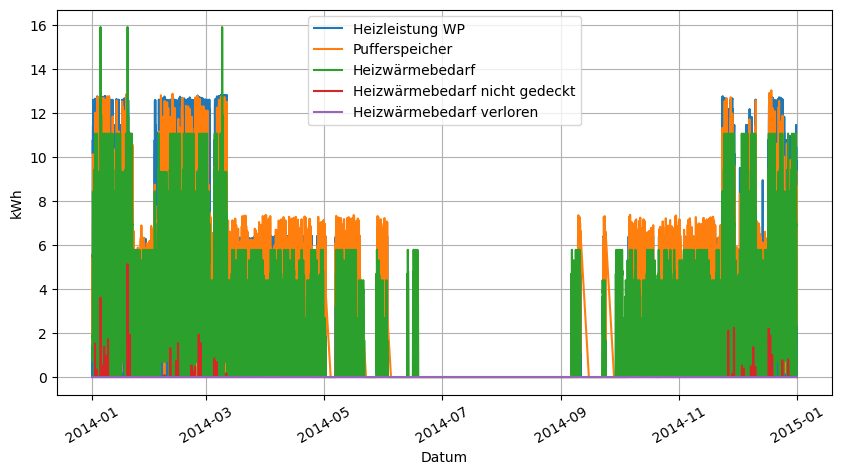

In [52]:
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]
#plt.rcParams["figure.autolayout"] = True

#plt.plot(df_ohne.index, df_ohne['Heizwärmebedarf'], label = "Heizwärmebedarf") 
plt.plot(df_ohne.index, df_ohne['Heizleistung WP'], label = "Heizleistung WP")  
#plt.plot(df_ohne.index, df_ohne['Heizleistung'], label = "Heizleistung") 
plt.plot(df_ohne.index, df_ohne['Wärmegehalt PS'], label = "Pufferspeicher")  
plt.plot(df_ohne.index, df_ohne['Heizwärmebedarf'], label = "Heizwärmebedarf") 
plt.plot(df_ohne.index, df_ohne['Deckung'], label = "Heizwärmebedarf nicht gedeckt") 
plt.plot(df_ohne.index, df_ohne['Verlust'], label = "Heizwärmebedarf verloren")
#plt.plot(df_ohne.index, df_ohne['State'], label = "State")
#plt.plot(df_ohne.index, df_ohne['temp_mittel'], label = "Mittlere Temperatur (48h)")
#plt.plot(df_ohne.index, df_ohne['wärmebedarf_mittel'], label = "Mittlere Wärmebedarf (3h)")

plt.xlabel('Datum', fontsize=10)
plt.ylabel('kWh', fontsize=10)
plt.legend(fontsize = 10, loc = 'best')
plt.grid(visible=True)
plt.xticks(rotation=30, fontsize=10)
#plt.xlim(pd.Timestamp('2014-01-01 00:00:00'), pd.Timestamp('2014-01-03 23:00:00')) 
plt.show()

In [50]:
print(df_ohne['Strombedarf WP'].sum())
print(df_ohne['Deckung'].sum())
print(df_ohne['Verlust'].sum())


5052.090363235122
55.076172923143695
0.0


In [5]:
importlib.reload(berechnen_wp)
df_1, P_el, COP = berechnen_wp.ohne_pv(df.copy(), Q_ps, PS_verlust, nenn_heizleistung)

The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




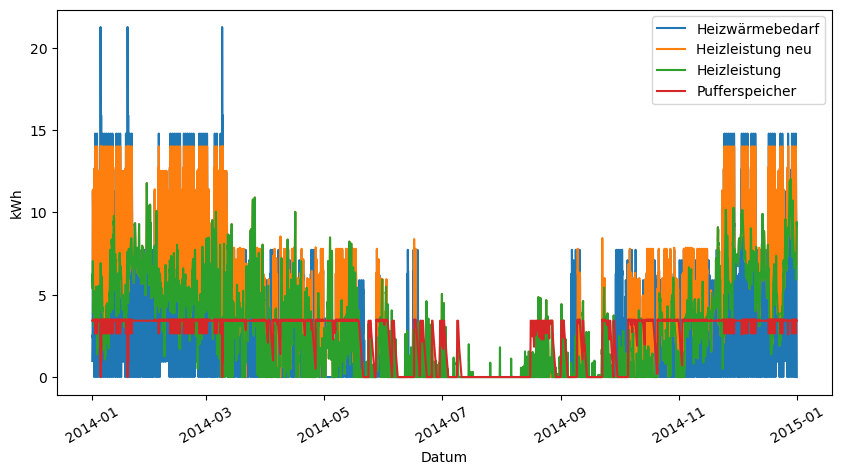

In [7]:
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]
#plt.rcParams["figure.autolayout"] = True

plt.plot(df_1.index, df_1['Heizwärmebedarf'], label = "Heizwärmebedarf")
plt.plot(df_1.index, df_1['Heizleistung neu'], label = "Heizleistung neu")  
plt.plot(df_1.index, df_1['Heizleistung'], label = "Heizleistung") 
plt.plot(df_1.index, df_1['Wärmegehalt PS'], label = "Pufferspeicher")   

plt.xlabel('Datum', fontsize=10)
plt.ylabel('kWh', fontsize=10)
plt.legend(fontsize = 10, loc = 'best')

plt.xticks(rotation=30, fontsize=10)
#plt.xlim(pd.Timestamp('2014-01-10 00:00:00'), pd.Timestamp('2014-01-13 23:00:00')) 
plt.show()

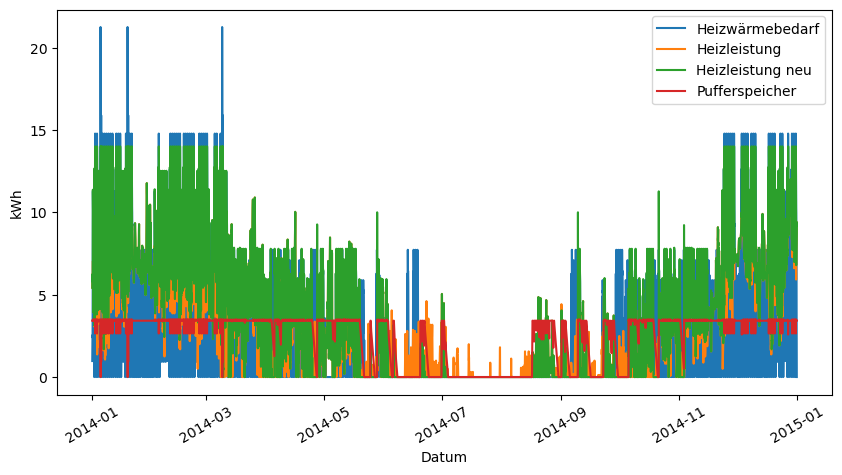

In [4]:
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]
#plt.rcParams["figure.autolayout"] = True

plt.plot(df_1.index, df_1['Heizwärmebedarf'], label = "Heizwärmebedarf")
plt.plot(df_1.index, df_1['Heizleistung'], label = "Heizleistung")
plt.plot(df_1.index, df_1['Heizleistung neu'], label = "Heizleistung neu")   
plt.plot(df_1.index, df_1['Wärmegehalt PS'], label = "Pufferspeicher")   

plt.xlabel('Datum', fontsize=10)
plt.ylabel('kWh', fontsize=10)
plt.legend(fontsize = 10, loc = 'best')

plt.xticks(rotation=30, fontsize=10)
#plt.xlim(pd.Timestamp('2014-01-10 00:00:00'), pd.Timestamp('2014-01-13 23:00:00')) 
plt.show()

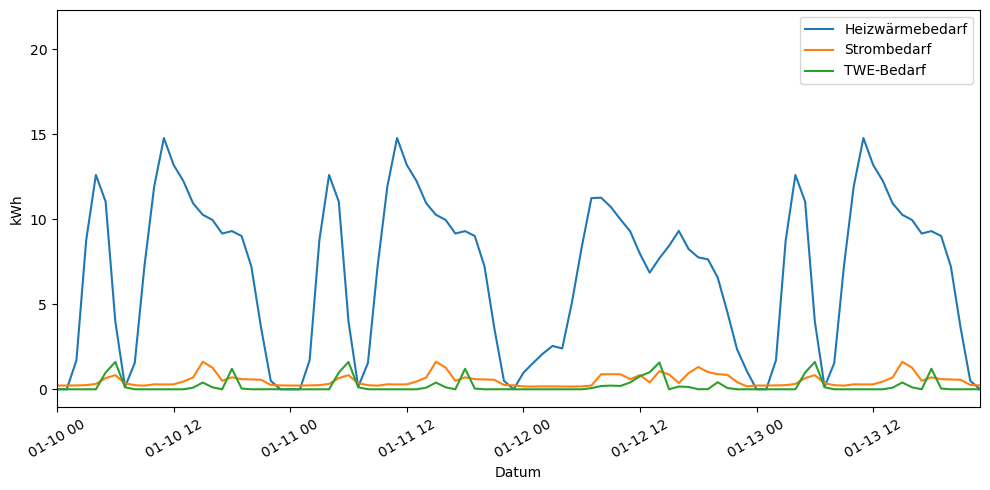

In [6]:
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]
#plt.rcParams["figure.autolayout"] = True

plt.plot(df.index, df['Heizwärmebedarf'], label = "Heizwärmebedarf")
plt.plot(df.index, df['Strombedarf'], label = "Strombedarf")
plt.plot(df.index, df['Warmwasserbedarf'], label = "TWE-Bedarf")   

plt.xlabel('Datum', fontsize=10)
plt.ylabel('kWh', fontsize=10)
plt.legend(fontsize = 10, loc = 'best')

plt.xticks(rotation=30, fontsize=10)
plt.xlim(pd.Timestamp('2014-01-10 00:00:00'), pd.Timestamp('2014-01-13 23:00:00')) 
plt.show()

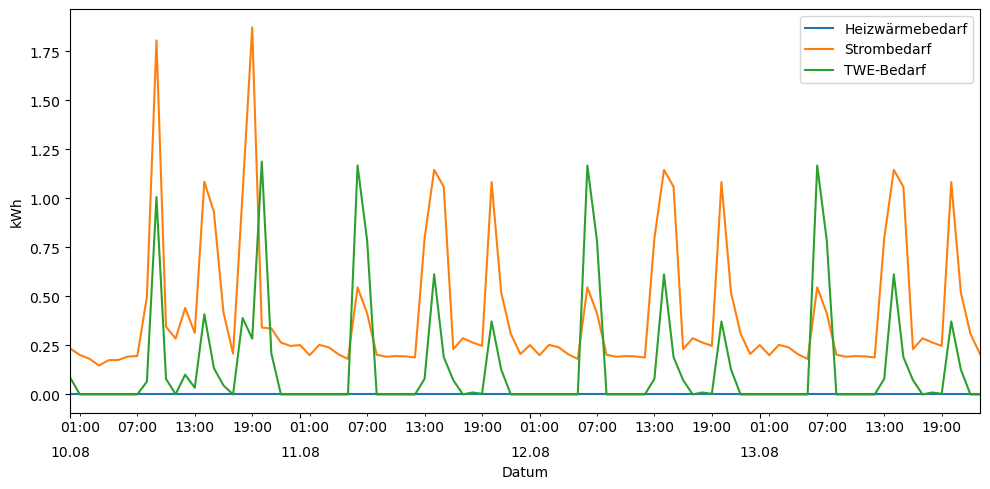

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

plt.rcParams["figure.figsize"] = [10, 5]

# Falls du nur einen bestimmten Zeitraum plotten willst, kannst du hier filtern:
start_date = "2014-08-10"
end_date = "2014-08-13"

df_filtered = df.loc[start_date:end_date]  # Dynamische Auswahl

# Daten plotten
plt.plot(df_filtered.index, df_filtered['Heizwärmebedarf'], label="Heizwärmebedarf")
plt.plot(df_filtered.index, df_filtered['Strombedarf'], label="Strombedarf")
plt.plot(df_filtered.index, df_filtered['Warmwasserbedarf'], label="TWE-Bedarf")

plt.xlabel('Datum', fontsize=10)
plt.ylabel('kWh', fontsize=10)
plt.legend(fontsize=10, loc='best')

# X-Achse anpassen
plt.xticks(fontsize=10)

# Datum-Format anpassen: Nur bei 00:00 Uhr das Datum, sonst nur die Uhrzeit
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=0))  # Haupt-Ticks nur um 00:00 Uhr
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))  # Format: Tag.Monat

ax.xaxis.set_minor_locator(mdates.HourLocator(interval=6))  # Alle 6h eine Nebenmarkierung
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))  # Uhrzeit anzeigen

# Abstand des Datums nach unten setzen
ax.xaxis.set_tick_params(labelsize=10, pad=20)  # Abstand vergrößern

# Automatische Anpassung der x-Achse basierend auf den Daten
ax.set_xlim([df_filtered.index.min(), df_filtered.index.max()])  # Dynamisch setzen

plt.show()


In [2]:
importlib.reload(berechnen_wp)
df_ohne, P_el, COP = berechnen_wp.ohne_pv(df.copy(), Q_ps, PS_verlust, nenn_heizleistung)

The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




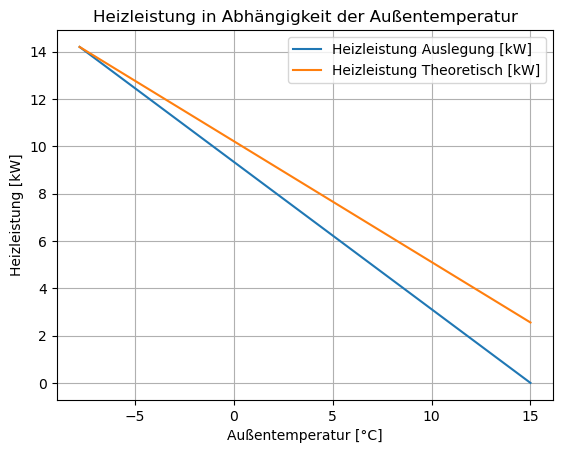

<module 'matplotlib.pyplot' from 'c:\\Users\\n-w\\anaconda3\\envs\\thesis_venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [11]:
import matplotlib.pyplot as plt 
%matplotlib inline
heizkurve.plot_heizleistung(heizleistung_auslegung)

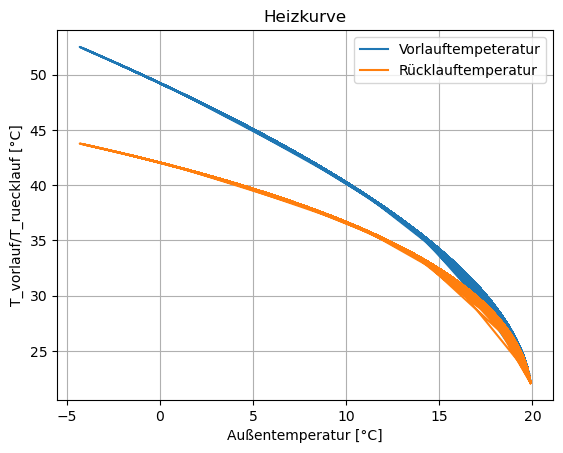

<module 'matplotlib.pyplot' from 'c:\\Users\\n-w\\anaconda3\\envs\\thesis_venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [10]:
%matplotlib inline
importlib.reload(heizkurve)
heizkurve.plot_heizkurve(hz)

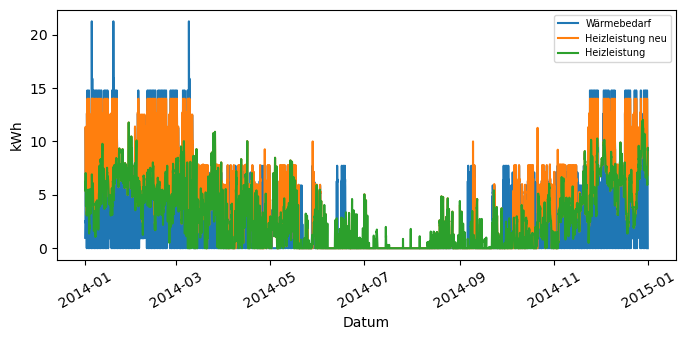

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.plot(df_ohne.index, df_ohne['Heizwärmebedarf'], label = "Wärmebedarf")
plt.plot(df_ohne.index, df_ohne['Heizleistung neu'], label = "Heizleistung neu")
plt.plot(df_ohne.index, df_ohne['Heizleistung'], label = "Heizleistung")   

plt.xlabel('Datum', fontsize=10)
plt.ylabel('kWh', fontsize=10)
plt.legend(fontsize = 7, loc = 'best')

plt.xticks(rotation=30, fontsize=10)
#plt.xlim(pd.Timestamp('2014-11-03 00:00:00'), pd.Timestamp('2014-11-06 23:00:00')) 
plt.show()

In [2]:
pv = pv_profil.get_pv_profil(40599, 2014, 10)
df_pv = berechnen_wp.mit_pv(df.copy(), pv)
df_pvbs = berechnen_wp.mit_pvbs(df.copy(), pv, 10, 11)

In [ ]:
importlib.reload(berechnen_wp)
strompreis = 0.358
ergebnisse_pv = berechnen_wp.ersparnis_pv(df_pv, 10, strompreis)
berechnen_wp.print_ersparnis(ergebnisse_pv)

In [ ]:
importlib.reload(berechnen_wp)
ergebnisse_bs = berechnen_wp.ersparnis_bs(df_pvbs, 10, strompreis)
berechnen_wp.print_ersparnis(ergebnisse_bs)

In [5]:
importlib.reload(berechnen_wp)
df_ev = berechnen_wp.mit_pvev(df.copy(), pv, True)

In [6]:
importlib.reload(berechnen_wp)
df_pvbsev = berechnen_wp.mit_pvbsev(df.copy(), pv, 10, 11, True)

In [ ]:
importlib.reload(berechnen_wp)
ergebnisse_ev = berechnen_wp.ersparnis_ev(df_ev, 10, 0.358)
berechnen_wp.print_ersparnis(ergebnisse_ev)

In [ ]:
importlib.reload(berechnen_wp)
ergebnisse_evbs = berechnen_wp.ersparnis_evbs(df_pvbsev, 10, 0.358)
berechnen_wp.print_ersparnis(ergebnisse_evbs)

## mit HEMS

In [ ]:
Q_ps

In [1]:
dichte = 1 # kg/m^3
c_wasser = 4.18 # kJ/(kg·K)
Q_ps_n = 10.69
V_ps_n = round(Q_ps_n/(dichte*c_wasser*(55 - 45)/3600), 3)
V_ps_n

920.67

In [3]:
Q_max = c_wasser*1*300*50
Q_max/3600

17.416666666666668

In [ ]:
round(3.48/(dichte*c_wasser*(55 - 45)/3600), 3)


In [ ]:
1.52/24

In [ ]:
3.583-1.875

In [ ]:
import matplotlib.pyplot as plt 
%matplotlib inline
heizkurve.plot_heizleistung(heizleistung_auslegung)

In [ ]:
df['Heizleistung'].max()